First trial

In [2]:
import gseapy as gp
import pandas as pd 

In [ ]:
degs_with_p_values = pd.read_csv('degs/DEGs_with_p_values.csv')
degs_with_p_values

In [ ]:
healthy_gene_exp = pd.read_csv("data/lusc-rsem-fpkm-tcga_paired.txt", sep="\t")
cancer_gene_exp = pd.read_csv("data/lusc-rsem-fpkm-tcga-t_paired.txt", sep="\t")
healthy_gene_exp

In [ ]:
healthy_class_vector = healthy_gene_exp.columns[2:].to_list()
cancer_class_vector = cancer_gene_exp.columns[2:].to_list()
healthy_class_vector

In [7]:
ranked_genes = degs_with_p_values[['Gene_Name', 'P_Value']].sort_values(
    by='P_Value', ascending=False
).set_index('Gene_Name')

# Save as a text file required for prerank analysis
ranked_genes_file = "ranked_genes.rnk"
ranked_genes.to_csv(ranked_genes_file, sep='\t', header=False)

In [ ]:
# Function to create the .cls file
def create_cls_file(healthy_file, cancer_file, output_cls_file, total_samples):
    # Read the sample IDs from the files
    with open(healthy_file, 'r') as f:
        healthy_samples = [line.strip() for line in f.readlines()]

    with open(cancer_file, 'r') as f:
        cancer_samples = [line.strip() for line in f.readlines()]
    healthy_samples = healthy_samples[1:]
    cancer_samples = cancer_samples[1:]
    
    print(len(healthy_samples)), print(len(cancer_samples))
    # Ensure the total number of samples match the sum of healthy and cancer samples
    assert len(healthy_samples) + len(cancer_samples) == total_samples, \
        "Total number of samples does not match the sum of healthy and cancer samples!"

    # Prepare class labels: '1' for cancer, '-1' for healthy
    cls_labels = ['-1'] * len(healthy_samples) + ['1'] * len(cancer_samples)

    # Prepare the .cls file content
    # 2 classes, total_samples samples, 1 per class
    cls_content = f"2 {total_samples} 1\n"
    cls_content += "\t".join(healthy_samples +
                             cancer_samples) + "\n"  # Sample IDs
    cls_content += " ".join(cls_labels) + "\n"  # Class labels

    # Write the content to the .cls file
    with open(output_cls_file, 'w') as f:
        f.write(cls_content)

    print(f"CLS file created successfully: {output_cls_file}")


# Define the input files and the output .cls file
healthy_file = 'data/lusc-rsem-fpkm-tcga_paired.txt'  # Replace with your actual file path
cancer_file = 'data/lusc-rsem-fpkm-tcga-t_paired.txt'    # Replace with your actual file path
output_cls_file = 'class_labels.cls'  # The output CLS file name

# Total number of samples (healthy + cancer)
total_samples = 19648 + 19648  # Modify based on your total number of samples

# Create the .cls file
create_cls_file(healthy_file, cancer_file, output_cls_file, total_samples)

In [9]:
# phenoA, phenoB, class_vector = gp.parser.gsea_cls_parser("./class_labels.cls")

In [ ]:
gs = gp.GSEA(
    data=cancer_gene_exp,
    gene_sets="gene sets/c4.all.v2024.1.Hs.symbols.gmt",
    classes=["Healthy", "Cancer"],
    outdir='gsea_results',
)

In [ ]:
gs.run()

Second trial

In [ ]:
# Run GSEA using GSEApy
gsea_results = gp.gsea(
    data=healthy_gene_exp,  # Path to the ranked list file
    gene_sets="./c4.all.v2024.1.Hs.symbols.gmt",  # Path to the gene set database
    cls=["Healthy", "Cancer"],  # Path to the class label file
    outdir="gsea_output",  # Output directory
)

# Print a summary of the results
print(gsea_results.res2d)

In [ ]:
terms = gsea_results.res2d.Term
axs = gsea_results.plot(terms[:5], show_ranking=False,
                  legend_kws={'loc': (1.05, 0)}, )

Final

In [ ]:
# Import the required libraries
import gseapy as gp
import pandas as pd

In [1]:
# Load the data
pvalues_file = 'degs/DEGs_with_p_values.csv'
log2fc_file = 'degs/lusc_degs_ranked_by_log2fc.csv'

# Read the CSV files
pvalues_df = pd.read_csv(pvalues_file)
log2fc_df = pd.read_csv(log2fc_file)

      Name                                    Term        ES       NES  \
0  prerank             Chemokine signaling pathway  0.633124  1.996476   
1  prerank                              Cell cycle -0.654871 -1.935556   
2  prerank  Cytokine-cytokine receptor interaction   0.57653  1.823487   
3  prerank    Leukocyte transendothelial migration   0.64946  1.800382   
4  prerank                                Lysosome  0.559537  1.710095   

  NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0       0.0       0.0        0.0  24/42  20.44%   
1       0.0  0.035573       0.05  18/33  17.77%   
2       0.0  0.056447       0.08  27/43  19.64%   
3       0.0    0.0669       0.11  12/18  20.44%   
4       0.0  0.122301        0.2  15/24  34.92%   

                                          Lead_genes  
0  CCL14;CX3CR1;CXCR1;GNG11;CXCR2;CXCL3;RASGRP2;S...  
1  CDKN2A;BUB1B;CDC25C;CCNA2;MAD2L1;MCM6;E2F1;DBF...  
2  CCL14;CX3CR1;CXCR1;ACVRL1;LEPR;CXCR2;CXCL3;TNF...  
3  CDH5;ESAM;CXCL12;PRKCB;GN

In [ ]:
# Merge the DataFrames on the common 'Gene_Name' column
merged_df = pd.merge(log2fc_df, pvalues_df, on='Gene_Name')

# Replace zero p-values to avoid log(0)
merged_df['P_Value'] = merged_df['P_Value'].replace(0, 1e-10)

In [ ]:
# Prepare ranked data for GSEA
ranked_data = merged_df[['Gene_Name', 'log2FC']
                        ].sort_values(by='log2FC', ascending=False)
ranked_data.columns = ['gene', 'score']

# Save the ranked data to a file (optional)
ranked_data_file = 'ranked_gene_list.rnk'
ranked_data.to_csv(ranked_data_file, sep='\t', index=False, header=False)

In [ ]:
# Run GSEA
gsea_results = gp.prerank(
    rnk=ranked_data_file,  # Use the ranked gene list file
    gene_sets='KEGG_2021_Human',  # Replace with your desired gene set
    outdir='GSEA_results',  # Output directory for results
    permutation_num=100,  # Number of permutations
)

# Inspect the results
gsea_results.res2d.head()

In [ ]:
# Save summary of results
gsea_results.res2d.to_csv('gsea_summary.csv', index=False)

"GSEA analysis completed and results saved!"

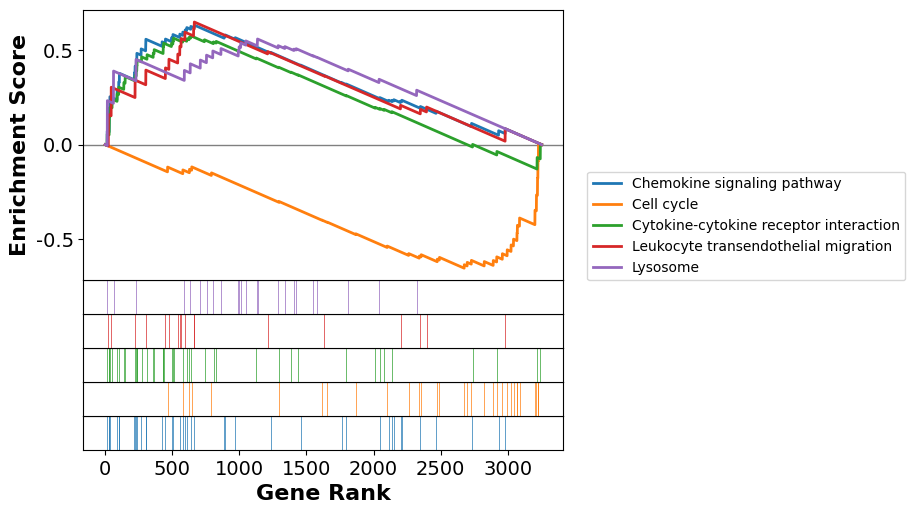

In [2]:

terms = gsea_results.res2d.Term
axs = gsea_results.plot(terms[:5], show_ranking=False,
                        legend_kws={'loc': (1.05, 0)}, )